## Collaborative Filtering

In general, Collaborative filtering (CF) is more commonly used than content-based systems because it usually gives better results and is relatively easy to understand (from an overall implementation perspective). The algorithm has the ability to do feature learning on its own, which means that it can start to learn for itself what features to use. 

CF can be divided into **Memory-Based Collaborative Filtering** and **Model-Based Collaborative filtering**. 

In this project, I will implement Model-Based CF by using singular value decomposition (SVD) and Memory-Based CF by computing cosine similarity.

In [1]:
import numpy as np
import pandas as pd

In [2]:
column_names = ['user_id','item_id','rating','timestamp']
df = pd.read_csv('u.data',sep='\t',names=column_names)
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [3]:
movie_titles = pd.read_csv('Movie_Id_Titles')
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [4]:
df = pd.merge(df,movie_titles,on ='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,0,172,5,881250949,"Empire Strikes Back, The (1980)"
2,0,133,1,881250949,Gone with the Wind (1939)
3,196,242,3,881250949,Kolya (1996)
4,186,302,3,891717742,L.A. Confidential (1997)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100003 entries, 0 to 100002
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    100003 non-null  int64 
 1   item_id    100003 non-null  int64 
 2   rating     100003 non-null  int64 
 3   timestamp  100003 non-null  int64 
 4   title      100003 non-null  object
dtypes: int64(4), object(1)
memory usage: 3.8+ MB


Now let's take a quick look at the number of unique users and movies.

In [6]:
n_users = df.user_id.nunique()
n_items = df.item_id.nunique()
print(n_users)
print(n_items)

944
1682


# Visualization Imports

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

In [8]:
# create a ratings dataframe with average rating and number of ratings:
df.groupby('title')['rating'].mean().sort_values(ascending= False) .head()

title
Aiqing wansui (1994)                                 5.0
Entertaining Angels: The Dorothy Day Story (1996)    5.0
Santa with Muscles (1996)                            5.0
Prefontaine (1997)                                   5.0
They Made Me a Criminal (1939)                       5.0
Name: rating, dtype: float64

In [9]:
df.groupby('title')['rating'].count().head().sort_values(ascending=False)

title
12 Angry Men (1957)          125
101 Dalmatians (1996)        109
187 (1997)                    41
'Til There Was You (1997)      9
1-900 (1994)                   5
Name: rating, dtype: int64

In [10]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


In [11]:
ratings['num_of_rating'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,num_of_rating
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


<Axes: >

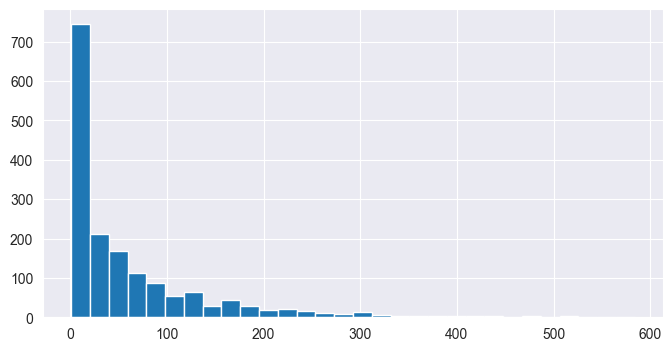

In [12]:
# now a histograms
plt.figure(figsize=(8,4))
ratings['num_of_rating'].hist(bins=30)

<Axes: >

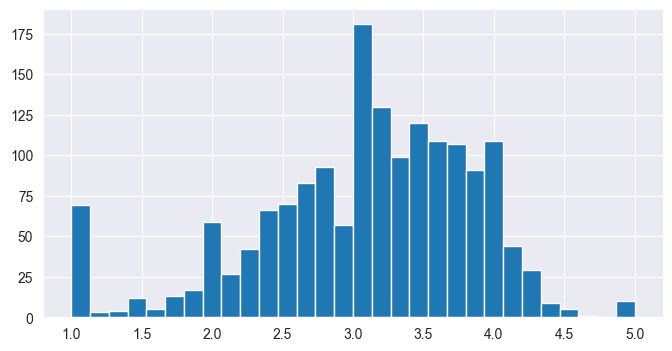

In [13]:
plt.figure(figsize=(8,4))
ratings['rating'].hist(bins=30)

<Figure size 600x300 with 0 Axes>

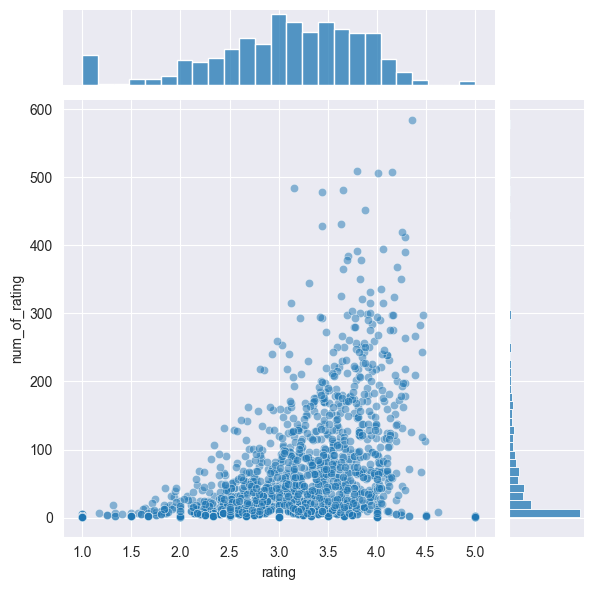

In [14]:
plt.figure(figsize=(6,3))
sns.jointplot(x='rating',y='num_of_rating',data = ratings,alpha=0.5)

# Train Test Split

In [15]:
from sklearn.model_selection import train_test_split
train_data,test_data = train_test_split(df,test_size=.3)

## Memory-Based Collaborative Filtering

In [16]:
train_data_matrix = np.zeros((n_users,n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1,line[2]-1]=line[3]

test_data_matrix=np.zeros((n_users,n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1,line[2]-1]=line[3]

In [17]:
from sklearn.metrics.pairwise import pairwise_distances
user_distance = pairwise_distances(train_data_matrix, metric='cosine')
# Convert distances to similarities
user_similarity = 1 - user_distance  # Similarity = 1 - Distance

item_distance = pairwise_distances(train_data_matrix.T, metric='cosine')
item_similarity = 1 - item_distance


    Item-Item Collaborative Filtering: “Users who liked this item also liked …”
    User-Item Collaborative Filtering: “Users who are similar to you also liked …”


In [18]:
def predict(ratings, similarity, type='user'):
    if type == 'user':  # User-based collaborative filtering
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':    # Item-based collaborative filtering
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred


In [19]:
# Predict ratings
user_prediction = predict(train_data_matrix, user_similarity, type='user')
item_prediction = predict(train_data_matrix, item_similarity, type='item')


## Evaluation
ther are many evaluation metrics but one of the most popular matric used to evaluate accuracy
of predicted rating is `root mean squraed error` (RMSE) but i can uses `mean_square_error`(MSE)funtion from sklearn .

Since I only want to consider predicted ratings that are in the test dataset,  so i filter out all other elements in the prediction matrix with `prediction[ground_truth.nonzero()]`.

In [20]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse (prediction,ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth= ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction,ground_truth))

In [21]:
print('User-based cf RMSE:'+ str(rmse(user_prediction,test_data_matrix)))
print('item-based cf RMSE:' + str(rmse(item_prediction,test_data_matrix)))

User-based cf RMSE:3.0157932651868733
item-based cf RMSE:3.2051091563995473


Model-based Collaborative Filtering

Model-based Collaborative Filtering is based on matrix factorization (MF) which has received greater exposure, mainly as an unsupervised learning method for latent variable decomposition and dimensionality reduction. Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF. The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items. When you have a very sparse matrix, with a lot of dimensions, by doing matrix factorization you can restructure the user-item matrix into low-rank structure, and you can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector. You fit this matrix to approximate your original matrix, as closely as possible, by multiplying the low-rank matrices together, which fills in the entries missing in the original matrix.

Let's calculate the sparsity level of MovieLens dataset:


In [22]:
sparsity = round(1.0-len(df)/float(n_users*n_items),3)
print('the sparsity lavel of movielens is' + str(sparsity*100) + '%')

the sparsity lavel of movielens is93.7%


To give an example of the learned latent preferences of the users and items: let's say for the MovieLens dataset you have the following information: (user id, age, location, gender, movie id, director, actor, language, year, rating). By applying matrix factorization the model learns that important user features are age group (under 10, 10-18, 18-30, 30-90), location and gender, and for movie features it learns that decade, director and actor are most important. Now if you look into the information you have stored, there is no such feature as the decade, but the model can learn on its own. The important aspect is that the CF model only uses data (user_id, movie_id, rating) to learn the latent features. If there is little data available model-based CF model will predict poorly, since it will be more difficult to learn the latent features.

Models that use both ratings and content features are called Hybrid Recommender Systems where both Collaborative Filtering and Content-based Models are combined. Hybrid recommender systems usually show higher accuracy than Collaborative Filtering or Content-based Models on their own: they are capable to address the cold-start problem better since if you don't have any ratings for a user or an item you could use the metadata from the user or item to make a prediction.



## SVD

A well-known matrix factorization method is Singular value decomposition (SVD). Collaborative Filtering can be formulated by approximating a matrix X by using singular value decomposition. The winning team at the Netflix Prize competition used SVD matrix factorization models to produce product recommendations, for more information I recommend to read articles: Netflix Recommendations: Beyond the 5 stars and Netflix Prize and SVD. The general equation can be expressed as follows: Image

Given m x n matrix X:

    U is an (m x r) orthogonal matrix
    S is an (r x r) diagonal matrix with non-negative real numbers on the diagonal
    V^T is an (r x n) orthogonal matrix

Elements on the diagnoal in S are known as singular values of X. 

In [23]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

In [24]:
u, s, vt = svds(train_data_matrix,k=20)
s_diag_matrix = np.diag(s)
x_pred = np.dot(np.dot(u,s_diag_matrix),vt)

In [25]:
print('user-based cf MSE :' + str (rmse(x_pred,test_data_matrix)))

user-based cf MSE :2.8050400838767438


Carelessly addressing only the relatively few known entries is highly prone to overfitting. SVD can be very slow and computationally expensive. More recent work minimizes the squared error by applying alternating least square or stochastic gradient descent and uses regularization terms to prevent overfitting. Alternating least square and stochastic gradient descent methods for CF will be covered in the next tutorials.

Review:

    We have covered how to implement simple Collaborative Filtering methods, both memory-based CF and model-based CF.
    Memory-based models are based on similarity between items or users, where we use cosine-similarity.
    Model-based CF is based on matrix factorization where we use SVD to factorize the matrix.
    Building recommender systems that perform well in cold-start scenarios (where little data is available on new users and items) remains a challenge. The standard collaborative filtering method performs poorly is such settings.

